# Predicting Solar Energy Production

In [1]:
# Importing all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
Sl_pr = pd.read_csv("Solar Energy.csv")
Sl_pr

,Data Through Date,Project ID,Interconnection Date,Utility,City/Town,County,Zip,Division,Substation,Circuit ID,Developer,Metering Method,Estimated PV System Size (kWdc),PV System Size (kWac),Estimated Annual PV Energy Production (kWh),Energy Storage System Size (kWac),Number of Projects
0,12/31/2023,SDG-66301,12/29/2023,Con Ed,Richmond Hill,Queens,11418.0,CENY-BK,Brownsville_2,9B05,Kamtech Solar Solutions,NM,6.05,5.17,7100,NaN,1
1,12/31/2023,SDG-66299,12/29/2023,Con Ed,Bronx,Bronx,10473.0,CENY-BX,Parkchester_2,5X67,Kamtech Solar Solutions,NM,6.74,5.76,7911,NaN,1
2,12/31/2023,SDG-66288,12/29/2023,Con Ed,Brooklyn,Kings,11225.0,CENY-BK,Bensonhurst_2,4B08,SUNCO,NM,3.05,2.61,3585,NaN,1
3,12/31/2023,SDG-66284,12/29/2023,Con Ed,Brooklyn,Kings,11236.0,CENY-BK,Bensonhurst_2,3037,Kamtech Solar Solutions,NM,5.62,4.80,6592,NaN,1
4,12/31/2023,SDG-66277,12/28/2023,Con Ed,Springfield Gardens,Queens,11413.0,CENY-Q,Jamaica,9112,Kamtech Solar Solutions,NM,6.05,5.17,7100,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218110,12/31/2023,49.0,12/19/2002,RGE,Ontario,Wayne,14519.0,Sodus,0205LS0237-1589 RTE 104,0205LS0237,NaN,NM,2.81,2.40,3296,NaN,1
218111,12/31/2023,48.0,9/24/2002,RGE,Friendship,Allegany,14739.0,Fillmore,8333GV7702-Friendship Nile RD,8333GV7702,NaN,NM,2.93,2.50,3433,NaN,1
218112,12/31/2023,NaN,7/1/2018,PSEGLI,NaN,Suffolk,11786.0,NaN,NaN,NaN,NaN,FIT,34362.00,24900.00,40335490,NaN,1
218113,12/31/2023,NaN,3/3/2018,PSEGLI,NaN,Suffolk,11933.0,NaN,NaN,NaN,NaN,FIT,27600.00,20000.00,32397984,NaN,1


# Data Preprocessing  

In [3]:
# Check for missing values in the dataset
missing_values = Sl_pr.isnull().sum()
print(missing_values)

Data Through Date                                   0
Project ID                                          3
Interconnection Date                                0
Utility                                             0
City/Town                                          58
County                                              0
Zip                                                96
Division                                        85234
Substation                                      79944
Circuit ID                                         30
Developer                                       10550
Metering Method                                   463
Estimated PV System Size (kWdc)                     0
PV System Size (kWac)                               0
Estimated Annual PV Energy Production (kWh)         0
Energy Storage System Size (kWac)              214024
Number of Projects                                  0
dtype: int64


In [4]:
# Drop columns with too many missing values
Sl_pr_cleaned = Sl_pr.drop(columns=['Division', 'Substation', 'Energy Storage System Size (kWac)'])

In [5]:
# Drop rows with missing 'Project ID' (since only 3 rows are missing)
Sl_pr_cleaned = Sl_pr_cleaned.dropna(subset=['Project ID'])

In [6]:
# For 'City/Town', fill missing values with the mode (most frequent value)
Sl_pr_cleaned['City/Town'] = Sl_pr_cleaned['City/Town'].fillna(Sl_pr_cleaned['City/Town'].mode()[0])

In [7]:
# For 'Zip', fill missing values with the mode
Sl_pr_cleaned['Zip'] = Sl_pr_cleaned['Zip'].fillna(Sl_pr_cleaned['Zip'].mode()[0])

In [8]:
# For 'Circuit ID', fill missing values with the mode
Sl_pr_cleaned['Circuit ID'] = Sl_pr_cleaned['Circuit ID'].fillna(Sl_pr_cleaned['Circuit ID'].mode()[0])

In [9]:
# For 'Metering Method', fill missing values with the mode
Sl_pr_cleaned['Metering Method'] = Sl_pr_cleaned['Metering Method'].fillna(Sl_pr_cleaned['Metering Method'].mode()[0])

In [10]:
# Developer has a significant amount of missing data. Dropping it might be an option.
Sl_pr_cleaned = Sl_pr_cleaned.drop(columns=['Developer'])

In [11]:
# Check for remaining missing values
print(Sl_pr_cleaned.isnull().sum())

Data Through Date                              0
Project ID                                     0
Interconnection Date                           0
Utility                                        0
City/Town                                      0
County                                         0
Zip                                            0
Circuit ID                                     0
Metering Method                                0
Estimated PV System Size (kWdc)                0
PV System Size (kWac)                          0
Estimated Annual PV Energy Production (kWh)    0
Number of Projects                             0
dtype: int64


In [12]:
# Convert 'Data Through Date' and 'Interconnection Date' to datetime objects
Sl_pr['Data Through Date'] = pd.to_datetime(Sl_pr['Data Through Date'], errors='coerce')
Sl_pr['Interconnection Date'] = pd.to_datetime(Sl_pr['Interconnection Date'], errors='coerce')

In [13]:
# Verify the conversion by checking the data types of the columns
print(Sl_pr[['Data Through Date', 'Interconnection Date']].dtypes)

Data Through Date       datetime64[ns]
Interconnection Date    datetime64[ns]
dtype: object


In [14]:
# You can extract additional time-based features, such as year or month, for further analysis
Sl_pr['Data Through Year'] = Sl_pr['Data Through Date'].dt.year
Sl_pr['Interconnection Year'] = Sl_pr['Interconnection Date'].dt.year

In [15]:
# Check if conversion was successful and view the newly created year columns
print(Sl_pr[['Data Through Date', 'Interconnection Date', 'Data Through Year', 'Interconnection Year']].head())

  Data Through Date Interconnection Date  Data Through Year  \
0        2023-12-31           2023-12-29               2023   
1        2023-12-31           2023-12-29               2023   
2        2023-12-31           2023-12-29               2023   
3        2023-12-31           2023-12-29               2023   
4        2023-12-31           2023-12-28               2023   

   Interconnection Year  
0                  2023  
1                  2023  
2                  2023  
3                  2023  
4                  2023  


In [16]:
# List of categorical columns to encode
categorical_columns = ['Utility', 'City/Town', 'County', 'Developer', 'Metering Method']

In [17]:
# Apply One-Hot Encoding to the specified categorical columns
Sl_pr_encoded = pd.get_dummies(Sl_pr, columns=categorical_columns, drop_first=True)

In [18]:
# Verify the new columns created from encoding
print(Sl_pr_encoded.head())

  Data Through Date Project ID Interconnection Date      Zip Division  \
0        2023-12-31  SDG-66301           2023-12-29  11418.0  CENY-BK   
1        2023-12-31  SDG-66299           2023-12-29  10473.0  CENY-BX   
2        2023-12-31  SDG-66288           2023-12-29  11225.0  CENY-BK   
3        2023-12-31  SDG-66284           2023-12-29  11236.0  CENY-BK   
4        2023-12-31  SDG-66277           2023-12-28  11413.0   CENY-Q   

      Substation Circuit ID  Estimated PV System Size (kWdc)  \
0  Brownsville_2       9B05                             6.05   
1  Parkchester_2       5X67                             6.74   
2  Bensonhurst_2       4B08                             3.05   
3  Bensonhurst_2       3037                             5.62   
4        Jamaica       9112                             6.05   

   PV System Size (kWac)  Estimated Annual PV Energy Production (kWh)  ...  \
0                   5.17                                         7100  ...   
1                   

# Feature Engineering

In [19]:
# Create a feature for the project age (in years)
# The age is the difference between the current date and the 'Interconnection Date'
Sl_pr['Project Age'] = pd.Timestamp.now().year - Sl_pr['Interconnection Date'].dt.year

In [20]:
# Extract the month from 'Interconnection Date' to capture seasonal trends
Sl_pr['Interconnection Month'] = Sl_pr['Interconnection Date'].dt.month

In [21]:
# Create a season feature based on the month (Winter, Spring, Summer, Fall)
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

In [22]:
Sl_pr['Season'] = Sl_pr['Interconnection Month'].apply(get_season)

In [23]:
# encode the 'Season' feature using one-hot encoding
Sl_pr = pd.get_dummies(Sl_pr, columns=['Season'], drop_first=True)

In [24]:
# Check the new features and dynamically extract all 'Season_' columns
# Find all columns that start with 'Season_'
season_columns = [col for col in Sl_pr.columns if col.startswith('Season_')]

In [25]:
# Print the relevant features including 'Interconnection Date', 'Project Age', 'Interconnection Month', and the one-hot encoded season columns
print(Sl_pr[['Interconnection Date', 'Project Age', 'Interconnection Month'] + season_columns].head())

  Interconnection Date  Project Age  Interconnection Month  Season_Spring  \
0           2023-12-29            1                     12          False   
1           2023-12-29            1                     12          False   
2           2023-12-29            1                     12          False   
3           2023-12-29            1                     12          False   
4           2023-12-28            1                     12          False   

   Season_Summer  Season_Winter  
0          False           True  
1          False           True  
2          False           True  
3          False           True  
4          False           True  


# Exploratory Data Analysis (EDA)

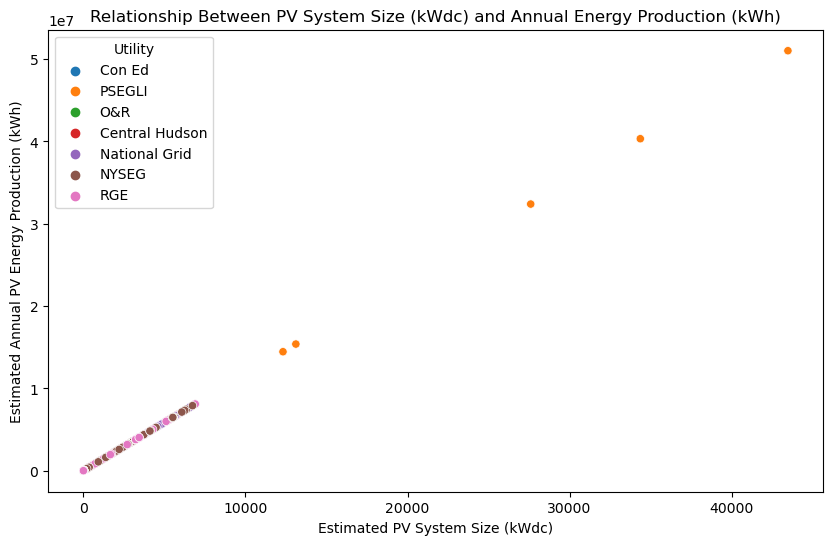

In [26]:
# Analyzing Relationship Between System Size and Energy Production

# Scatter plot to visualize relationship between Estimated PV System Size (kWdc) and Estimated Annual PV Energy Production (kWh)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=Sl_pr, x='Estimated PV System Size (kWdc)', y='Estimated Annual PV Energy Production (kWh)', hue='Utility')
plt.title('Relationship Between PV System Size (kWdc) and Annual Energy Production (kWh)')
plt.xlabel('Estimated PV System Size (kWdc)')
plt.ylabel('Estimated Annual PV Energy Production (kWh)')
plt.show()

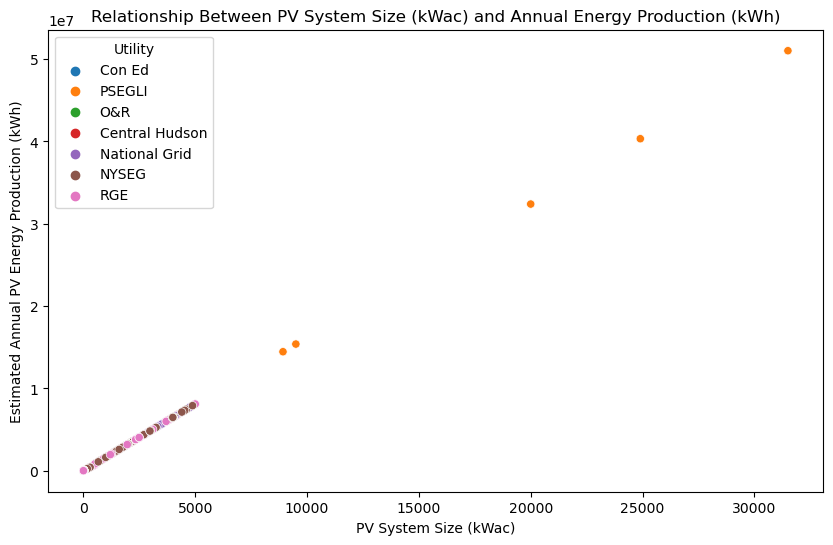

In [27]:
# Scatter plot to visualize relationship between PV System Size (kWac) and Estimated Annual PV Energy Production (kWh)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=Sl_pr, x='PV System Size (kWac)', y='Estimated Annual PV Energy Production (kWh)', hue='Utility')
plt.title('Relationship Between PV System Size (kWac) and Annual Energy Production (kWh)')
plt.xlabel('PV System Size (kWac)')
plt.ylabel('Estimated Annual PV Energy Production (kWh)')
plt.show()

In [28]:
# Create a pivot table to get average energy production by ZIP
zip_energy = Sl_pr.groupby('Zip')['Estimated Annual PV Energy Production (kWh)'].mean().reset_index()

In [29]:
# Check for missing ZIP codes
print(zip_energy.isnull().sum())

Zip                                            0
Estimated Annual PV Energy Production (kWh)    0
dtype: int64


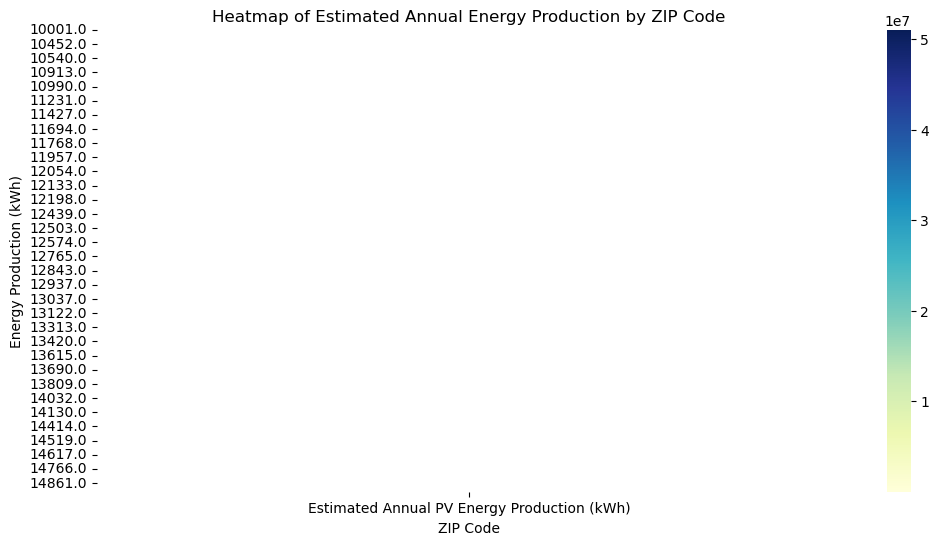

In [30]:
# For simplicity, we'll use a heatmap to visualize energy production by ZIP if lat/lon data is missing
plt.figure(figsize=(12, 6))
sns.heatmap(zip_energy.pivot_table(values='Estimated Annual PV Energy Production (kWh)', index='Zip'), cmap='YlGnBu', linewidths=0.5)
plt.title('Heatmap of Estimated Annual Energy Production by ZIP Code')
plt.xlabel('ZIP Code')
plt.ylabel('Energy Production (kWh)')
plt.show()

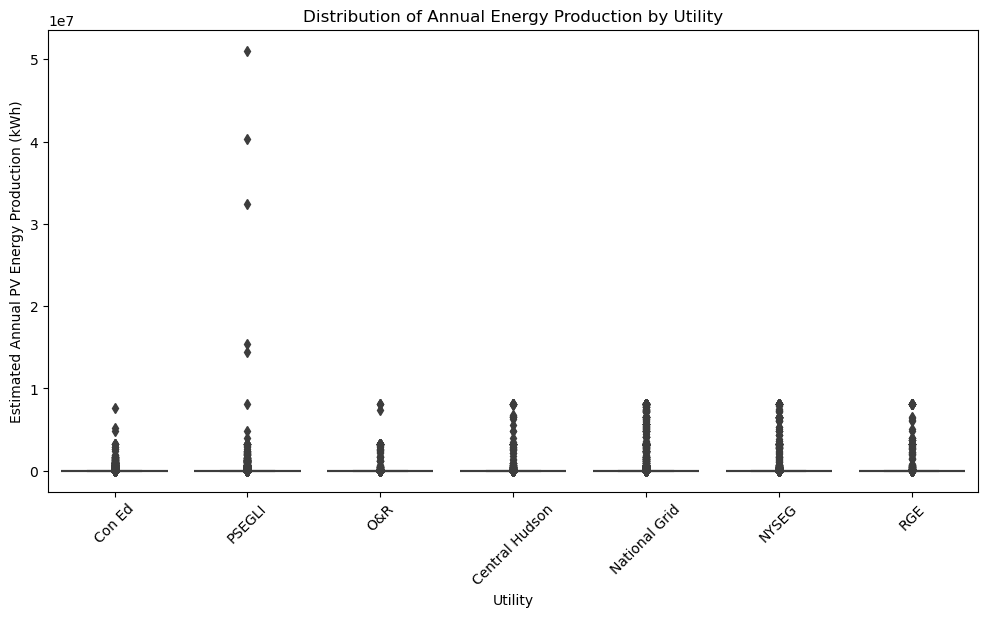

In [31]:
# Analyzing Distribution of Categorical Features

# Distribution of Estimated Annual Energy Production (kWh) across different Utilities
plt.figure(figsize=(12, 6))
sns.boxplot(data=Sl_pr, x='Utility', y='Estimated Annual PV Energy Production (kWh)')
plt.title('Distribution of Annual Energy Production by Utility')
plt.xticks(rotation=45)
plt.show()

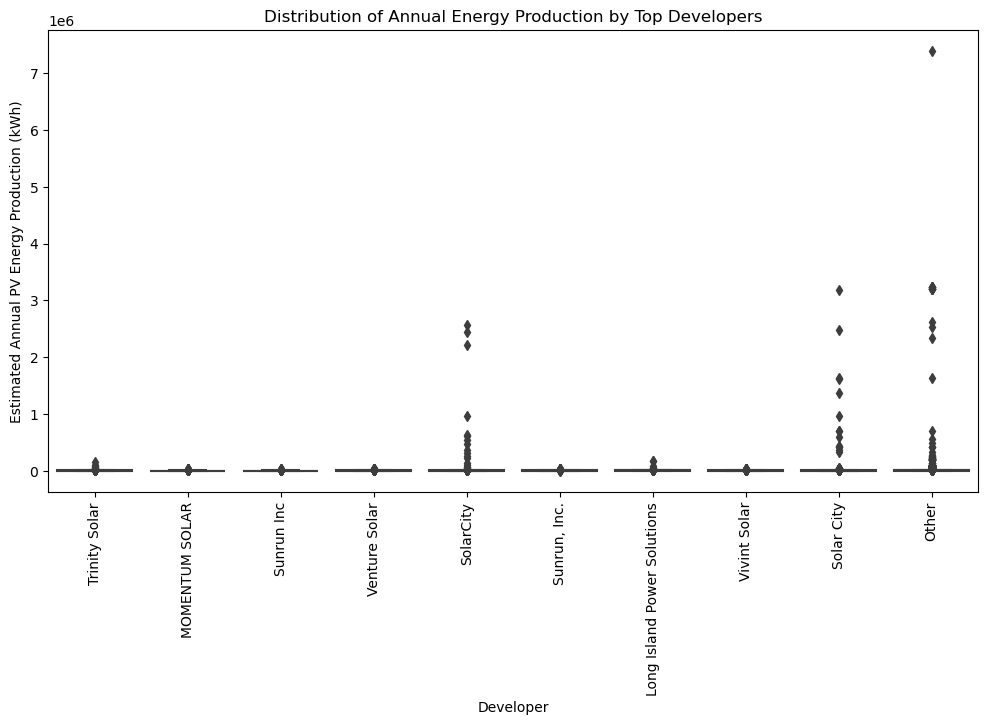

In [32]:
# Distribution of Estimated Annual Energy Production (kWh) across different Developers
plt.figure(figsize=(12, 6))
top_developers = Sl_pr['Developer'].value_counts().nlargest(10).index  # Select top 10 developers
sns.boxplot(data=Sl_pr[Sl_pr['Developer'].isin(top_developers)], x='Developer', y='Estimated Annual PV Energy Production (kWh)')
plt.title('Distribution of Annual Energy Production by Top Developers')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# 4. Pairplot to see relationships between numeric variables
sns.pairplot(Sl_pr[['Estimated PV System Size (kWdc)', 'PV System Size (kWac)', 'Estimated Annual PV Energy Production (kWh)']])
plt.suptitle('Pairplot of System Size and Energy Production', y=1.02)
plt.show()

In [ ]:
# Select Features and Target
# We'll select features such as system size, developer, utility, and others that are relevant for prediction
features = ['Estimated PV System Size (kWdc)', 'PV System Size (kWac)', 'Developer', 'Utility', 'City/Town', 'County']

In [ ]:
# Remove rows with missing target values
Sl_pr = Sl_pr.dropna(subset=['Estimated Annual PV Energy Production (kWh)'])

In [ ]:
# Separate X (features) and y (target)
X = Sl_pr[features]
y = Sl_pr['Estimated Annual PV Energy Production (kWh)']

In [ ]:
# Handle Categorical Variables using OneHotEncoding for Developer, Utility, City/Town, County
categorical_columns = ['Developer', 'Utility', 'City/Town', 'County']
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_columns]), columns=encoder.get_feature_names_out(categorical_columns))

In [ ]:
# Combine encoded categorical features with numerical ones
X_encoded = pd.concat([X_encoded, X[['Estimated PV System Size (kWdc)', 'PV System Size (kWac)']].reset_index(drop=True)], axis=1)

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [ ]:
# Define a simple model - we'll use RandomForestRegressor for this example
model = RandomForestRegressor(n_estimators=100, random_state=42)

In [ ]:
# Train the model
model.fit(X_train, y_train)

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)

In [ ]:
# Evaluate the model performance using Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

# Feature Selection

In [ ]:
Sl_pr_sampled = Sl_pr.sample(frac=0.1, random_state=42)

In [ ]:
# Convert 'Interconnection Date' to datetime if not already
Sl_pr_sampled['Interconnection Date'] = pd.to_datetime(Sl_pr_sampled['Interconnection Date'])

In [ ]:
# Create new time-related features from 'Interconnection Date'
Sl_pr_sampled['Interconnection Year'] = Sl_pr_sampled['Interconnection Date'].dt.year
Sl_pr_sampled['Interconnection Month'] = Sl_pr_sampled['Interconnection Date'].dt.month
Sl_pr_sampled['Interconnection Day'] = Sl_pr_sampled['Interconnection Date'].dt.day

In [ ]:
# Drop the original 'Interconnection Date' column
Sl_pr_sampled = Sl_pr_sampled.drop(columns=['Interconnection Date'])

In [ ]:
# List of possible features
features = [
    'Estimated PV System Size (kWdc)', 'PV System Size (kWac)',
    'Utility', 'City/Town', 'Division', 'Substation', 'Developer',
    'Interconnection Year', 'Interconnection Month', 'Interconnection Day'
]

In [ ]:
# Handle categorical variables using OneHotEncoder (for categorical features like Utility, City/Town, etc.)
categorical_cols = ['Utility', 'City/Town', 'Division', 'Substation', 'Developer']
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_features = pd.DataFrame(encoder.fit_transform(Sl_pr_sampled[categorical_cols]))

In [ ]:
# Rename encoded feature columns
encoded_features.columns = encoder.get_feature_names_out(categorical_cols)

In [ ]:
# Target variable
y = Sl_pr_sampled['Estimated Annual PV Energy Production (kWh)']

In [ ]:
# Add back time-related and numerical features
time_numerical_cols = ['Estimated PV System Size (kWdc)', 'PV System Size (kWac)', 'Interconnection Year', 'Interconnection Month', 'Interconnection Day']
X = pd.concat([Sl_pr_sampled[time_numerical_cols].reset_index(drop=True), encoded_features.reset_index(drop=True)], axis=1)

In [ ]:
# Now check the length of X and y to confirm they match
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

In [ ]:
# Ensure consistent indices between X and y (just in case)
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

In [ ]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train a Random Forest Regressor for feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

In [ ]:
# Feature Importance using Random Forest
rf_importances = rf.feature_importances_
rf_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf_importances}).sort_values(by='Importance', ascending=False)

In [ ]:
# Plot Random Forest Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=rf_importance_df.head(10))
plt.title('Top 10 Feature Importances (Random Forest)')
plt.show()

In [ ]:
# Train an XGBoost Regressor for feature importance
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

In [ ]:
# Feature Importance using XGBoost
xgb_importances = xgb_model.feature_importances_
xgb_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': xgb_importances}).sort_values(by='Importance', ascending=False)

In [ ]:
# Plot XGBoost Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=xgb_importance_df.head(10))
plt.title('Top 10 Feature Importances (XGBoost)')
plt.show()

In [ ]:
# Optionally, check correlation matrix for numerical features
corr = Sl_pr_sampled[['Estimated PV System Size (kWdc)', 'PV System Size (kWac)', 'Estimated Annual PV Energy Production (kWh)']].corr()

In [ ]:
# Plot heatmap of the correlations
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Numerical Features')
plt.show()

# Model Selection

In [ ]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Function to evaluate model performance
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{model.__class__.__name__} Performance:")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R² Score: {r2}")
    print("-" * 40)
    
    return mse, r2

In [ ]:
# Linear Regression
linear_model = LinearRegression()
evaluate_model(linear_model, X_train, X_test, y_train, y_test)

In [ ]:
# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
evaluate_model(rf_model, X_train, X_test, y_train, y_test)

In [ ]:
# Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
evaluate_model(gbr_model, X_train, X_test, y_train, y_test)

In [ ]:
# Neural Network Regressor (MLP)
mlp_model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=500, random_state=42)
evaluate_model(mlp_model, X_train, X_test, y_train, y_test)

In [ ]:
# Optionally, you can compare models using cross-validation to get a better understanding of their generalization performance
def cross_validate_model(model, X, y):
    # Perform 5-fold cross-validation
    mse_scores = -cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)
    r2_scores = cross_val_score(model, X, y, scoring='r2', cv=5)
    
    print(f"{model.__class__.__name__} Cross-Validation:")
    print(f"Mean Squared Error (MSE): {np.mean(mse_scores)}")
    print(f"R² Score: {np.mean(r2_scores)}")
    print("-" * 40)

# Cross-validate models
cross_validate_model(linear_model, X, y)
cross_validate_model(rf_model, X, y)
cross_validate_model(gbr_model, X, y)
cross_validate_model(mlp_model, X, y)

# Model Tuning and Optimization

In [ ]:
# Function to perform hyperparameter tuning using GridSearchCV
def tune_model(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                               cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
    
    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)
    
    print(f"Best Parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    print(f"Best Score for {model.__class__.__name__}: {-grid_search.best_score_}")
    print("-" * 40)
    
    return grid_search.best_estimator_

In [ ]:
# Define the models and parameter grids for tuning

# Linear Regression doesn't have many tunable hyperparameters, but we will apply scaling
linear_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('linear_model', LinearRegression())
])
linear_param_grid = {}

# Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Gradient Boosting
gbr_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# MLP Regressor (Neural Network)
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling for neural networks
    ('mlp_model', MLPRegressor(max_iter=1000, random_state=42))
])
mlp_param_grid = {
    'mlp_model__hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'mlp_model__activation': ['relu', 'tanh'],
    'mlp_model__solver': ['adam', 'sgd'],
    'mlp_model__learning_rate': ['constant', 'adaptive']
}

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Perform hyperparameter tuning for each model
# Linear Regression doesn't require tuning, but we apply scaling
tuned_linear_model = tune_model(linear_pipeline, linear_param_grid, X_train, y_train)

# Random Forest tuning
rf_model = RandomForestRegressor(random_state=42)
tuned_rf_model = tune_model(rf_model, rf_param_grid, X_train, y_train)

# Gradient Boosting tuning
gbr_model = GradientBoostingRegressor(random_state=42)
tuned_gbr_model = tune_model(gbr_model, gbr_param_grid, X_train, y_train)

# MLP Regressor tuning
tuned_mlp_model = tune_model(mlp_pipeline, mlp_param_grid, X_train, y_train)

In [ ]:
# Function to evaluate the tuned models on test data
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{model.__class__.__name__} Performance after Tuning:")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R² Score: {r2}")
    print("-" * 40)
    
    return rmse, mae, r2

# 6. Evaluate the tuned models
evaluate_model(tuned_linear_model, X_test, y_test)
evaluate_model(tuned_rf_model, X_test, y_test)
evaluate_model(tuned_gbr_model, X_test, y_test)
evaluate_model(tuned_mlp_model, X_test, y_test)